In [174]:
import json
import urllib

from IPython.display import Image

# searching tools
from satsearch import Search
import geojsonio
from shapely.geometry import shape

# visualizing data tools
import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform_bounds
from rasterio.windows import Window
from rio_tiler.utils import get_vrt_transform
import numpy as np
from PIL import Image as PILImage

# Finding Imagery

Let's search for Landsat imagery over Yokohama. Development Seed [hosts an instance](https://sat-api.developmentseed.org/search/stac) of [`sat-api`](https://github.com/sat-utils/sat-api), an open source, [STAC](https://github.com/radiantearth/stac-spec) compliant API for searching for imagery.

In [115]:
# AOI over Yokohama expressed as GeoJSON
aoi = {
    "type": "Polygon",
    "coordinates":[
        [
            [139.60,35.38],
            [139.69,35.38],
            [139.69,35.45],
            [139.60,35.45],
            [139.60,35.38]
        ]
    ]
}

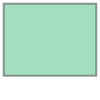

In [116]:
shape(aoi)

In [68]:
# View GeoJSON on https://geojson.io
# This site can also be used for creating an AOI
geojsonio.display(json.dumps(aoi))

'http://geojson.io/#data=data:application/json,%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B139.6%2C%2035.38%5D%2C%20%5B139.69%2C%2035.38%5D%2C%20%5B139.69%2C%2035.45%5D%2C%20%5B139.6%2C%2035.45%5D%2C%20%5B139.6%2C%2035.38%5D%5D%5D%7D'

In [143]:
# Choose other filters for our imagery
START_DATE = '2019-01-01T00:00:00Z'
END_DATE = '2019-05-01T23:59:59Z'
BOUNDING_BOX = shape(aoi).bounds
MIN_CLOUD_COVER = 0
MAX_CLOUD_COVER = 10

results = (
            Search(
                bbox=BOUNDING_BOX,
                time=f"{START_DATE}/{END_DATE}",
                query={
                    "eo:cloud_cover": {"gte": MIN_CLOUD_COVER, "lte": MAX_CLOUD_COVER},
                    "eo:sun_elevation": {"gt": 0},
                    "landsat:tier": {"eq": "T1"},
                    "collection": {"eq": "landsat-8-l1"},
                },
                sort=[
                    {"field": "eo:cloud_cover", "direction": "desc"},
                    {"field": "datetime", "direction": "asc"}
                ]
            )
            .items()
            .geojson()
        )

In [144]:
# Show how many scenes were returned
len(results['features'])

3

In [87]:
# Since the response is also GeoJSON, we can view the scene boundaries
geojsonio.display(json.dumps(results))

'http://geojson.io/#data=data:application/json,%7B%22type%22%3A%20%22FeatureCollection%22%2C%20%22features%22%3A%20%5B%7B%22type%22%3A%20%22Feature%22%2C%20%22id%22%3A%20%22LC81070362019021LGN00%22%2C%20%22bbox%22%3A%20%5B138.43628%2C%2033.52151%2C%20141.00442%2C%2035.67859%5D%2C%20%22geometry%22%3A%20%7B%22type%22%3A%20%22Polygon%22%2C%20%22coordinates%22%3A%20%5B%5B%5B138.95670775184857%2C%2035.67810760098585%5D%2C%20%5B141.00269164906928%2C%2035.264447667547756%5D%2C%20%5B140.48282473413462%2C%2033.52300444369077%5D%2C%20%5B138.43893296681392%2C%2033.94330696553546%5D%2C%20%5B138.95670775184857%2C%2035.67810760098585%5D%5D%5D%7D%2C%20%22properties%22%3A%20%7B%22collection%22%3A%20%22landsat-8-l1%22%2C%20%22datetime%22%3A%20%222019-01-21T01%3A16%3A02.369095%2B00%3A00%22%2C%20%22eo%3Asun_azimuth%22%3A%20153.54662883%2C%20%22eo%3Asun_elevation%22%3A%2030.80294492%2C%20%22eo%3Acloud_cover%22%3A%207%2C%20%22eo%3Arow%22%3A%20%22036%22%2C%20%22eo%3Acolumn%22%3A%20%22107%22%2C%20%22landsat%

In [117]:
# Show all the available dictionary keys on each scene/feature
first_scene = results['features'][0]
first_scene.keys()

dict_keys(['type', 'id', 'bbox', 'geometry', 'properties', 'assets', 'links'])

In [119]:
# Show all the available scene properties (metadata)
list(first_scene['properties'].keys())

['collection',
 'datetime',
 'eo:sun_azimuth',
 'eo:sun_elevation',
 'eo:cloud_cover',
 'eo:row',
 'eo:column',
 'landsat:product_id',
 'landsat:scene_id',
 'landsat:processing_level',
 'landsat:tier',
 'eo:epsg',
 'eo:instrument',
 'eo:off_nadir',
 'eo:platform',
 'eo:bands',
 'eo:gsd']

In [120]:
# Show all the available scene assets (data)
list(first_scene['assets'].keys())

['index',
 'thumbnail',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'ANG',
 'MTL',
 'BQA']

## Downloading Imagery

Now let's download imagery. But instead of getting the whole file, let's save bandwidth and only grab the data we need. Because the files are organized as [Cloud-Optimized GeoTIFF](https://trac.osgeo.org/gdal/wiki/CloudOptimizedGeoTIFF)

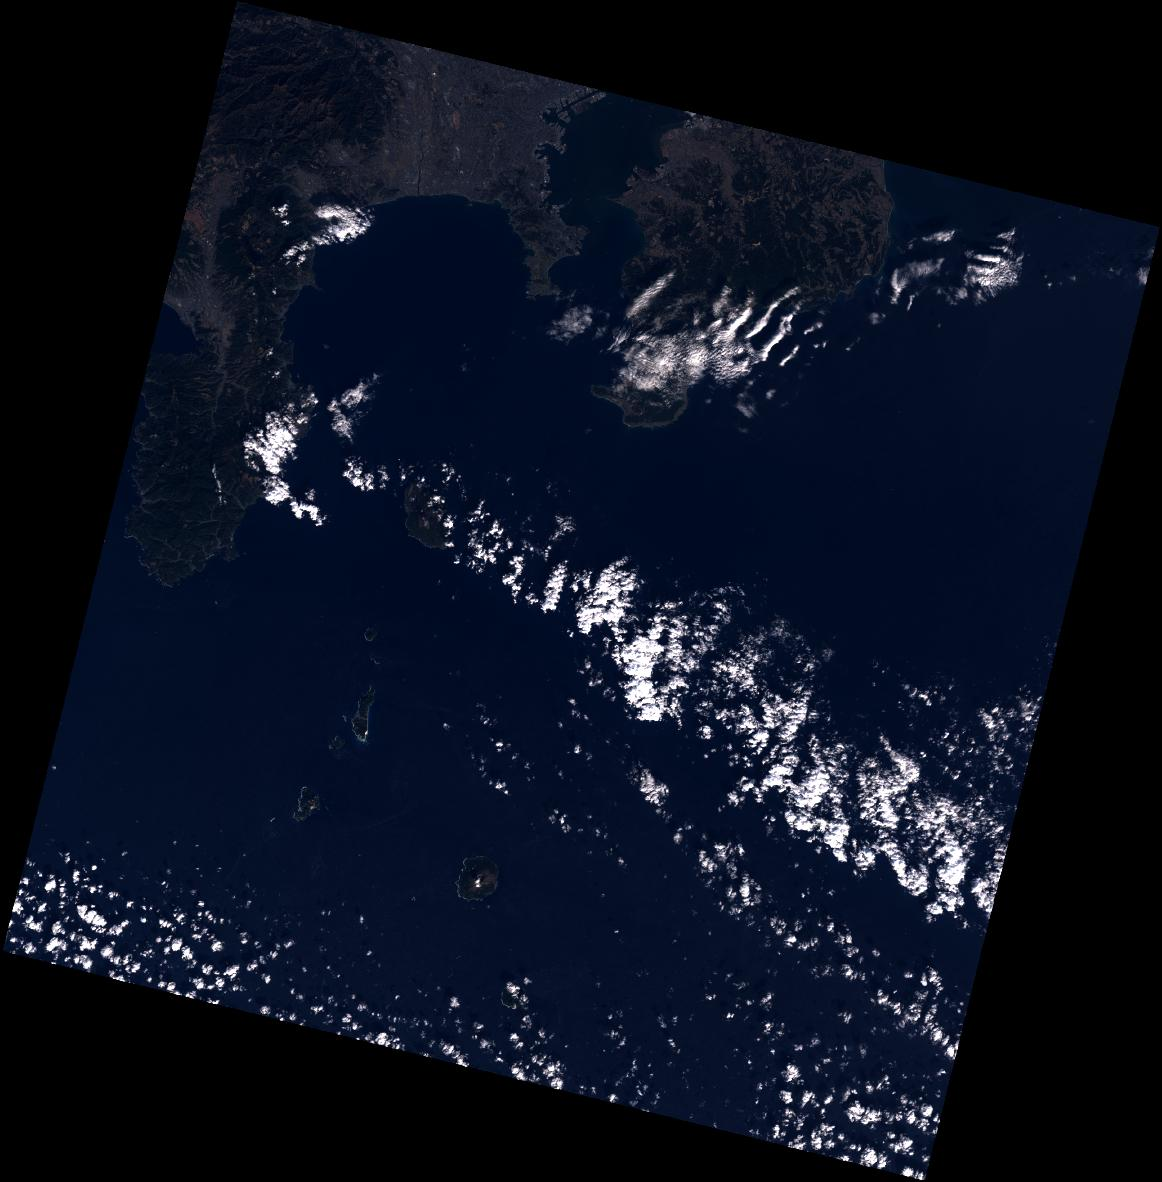

In [196]:
# View the scene thumbnail before downloading any large files
thumbnail = first_scene['assets']['thumbnail']
Image(thumbnail['href'])

In [106]:
# The thumbnail is only 116 kB
r = urllib.request.urlopen(first_scene['assets']['thumbnail']['href'])
f'{r.info()["Content-Length"]} bytes'

'119338 bytes'

In [131]:
# One band of the actual data is 53.6 MB
red_band = first_scene['assets']['B4']['href']
r = urllib.request.urlopen(red_band)
f'{r.info()["Content-Length"]} bytes'

'56195049 bytes'

In [132]:
# We can use rasterio to read the file headers and see how the data is organized before downloading
# Landsat files are arranged into easily downloadable square blocks which isn't true of GeoTIFF files in general
with rasterio.open(red_band) as src:
    print(src.block_shapes)
    
dg_open_url = 'https://opendata.digitalglobe.com/hurricane-florence/pre-event/2018-01-01/10400100380D1C00/0302213.tif'

with rasterio.open(dg_open_url) as src:
    print(src.block_shapes)

[(512, 512)]
[(1, 19584), (1, 19584), (1, 19584)]


In [195]:
def get_window(src, latlng_bbox):
    bounds = transform_bounds(CRS({ 'init': 'EPSG:4326' }), src.crs,  *latlng_bbox)
    transform, width, height = get_vrt_transform(src, bounds, dst_crs=src.crs)
    col_off = round((transform[2] - src.transform[2]) / src.transform[0])
    row_off = round((transform[5] - src.transform[5]) / src.transform[4])
    return Window(col_off=col_off, row_off=row_off, width=width, height=height)


with rasterio.open(red_band) as src:
    window = get_window(src, bbox)
    print(window)
    array = src.read(1, window=window)

Window(col_off=3498, row_off=816, width=276, height=263)


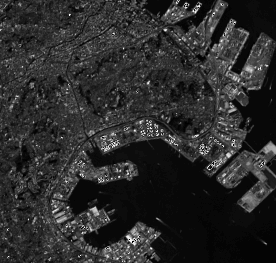

In [218]:
def scale_array(arr):
    a_min = np.min(arr)
    a_max = np.max(arr)
    return ((arr - a_min) / (a_max - a_min) * 255).astype(np.uint8)

scaled_array = scale_array(array)
PILImage.fromarray(scaled_array * 4)

In [198]:
bands = ['B4', 'B3', 'B2']
band_data = []
for band in bands:
    band_url = first_scene['assets'][band]['href']
    with rasterio.open(band_url) as band_src:
        window = get_window(band_src, bbox)
        array = band_src.read(1, window=window)
        band_data.append(array)    

AxisError: axis 2 is out of bounds for array of dimension 1

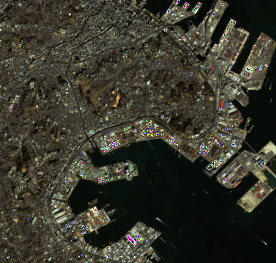

In [217]:
scaled_bands = [scale_array(a) * 4 for a in band_data]
PILImage.fromarray(np.stack(scaled_bands, axis=2))